In [1]:
import os,sys
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import torch
from rembg import remove
from torchvision import transforms
from sklearn.model_selection import train_test_split
from classes.generate_data import image_proc,imagegen
from classes.splitter import  train_val_splitter

# Generation

In [6]:
class image_proc_2(image_proc):
    
    def __init__(self, img_dir, output_dir):
        super().__init__(img_dir, output_dir)
        return
    
    def load_model(self):
        model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
        model.eval()
        return model

    def make_transparent_foreground(self,pic, mask):
        b, g, r = cv2.split(np.array(pic).astype('uint8'))
        a = np.ones(mask.shape, dtype='uint8') * 255
        alpha_im = cv2.merge([b, g, r, a], 4)
        bg = np.zeros(alpha_im.shape)
        new_mask = np.stack([mask, mask, mask, mask], axis=2)
        foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

        return foreground

    def get_foreground(self,model, input_file):
        input_image = input_file
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0) 

        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')

        with torch.no_grad():
            output = model(input_batch)['out'][0]
        output_predictions = output.argmax(0)

        mask = output_predictions.byte().cpu().numpy()
        background = np.zeros(mask.shape)
        bin_mask = np.where(mask, 255, background).astype(np.uint8)

        foreground = self.make_transparent_foreground(input_image ,bin_mask)

        return foreground
    
    def remove_background(self, limit=None):
        print('removing background')
        self.load_imgs(limit=limit)
        model = self.load_model()
        for i in range(len(self.imgs)):
            # if i%(len(self.imgs)//100) == 0:
            #     print(i)
            tmp = self.imgs[i]
            self.imgs[i] = Image.fromarray(self.get_foreground(model,tmp))
            display(self.imgs[i])
            self.imgs[i].filename = tmp.filename
        return 


removing background


Using cache found in /home/sharan/.cache/torch/hub/pytorch_vision_v0.10.0
/home/sharan/Desktop/python/Grouped-imagegen/.environment/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sharan/Desktop/python/Grouped-imagegen/.environment/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


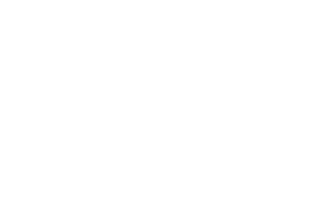

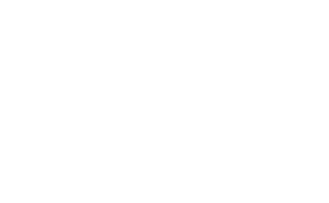

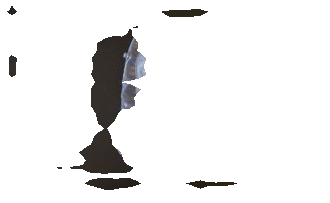

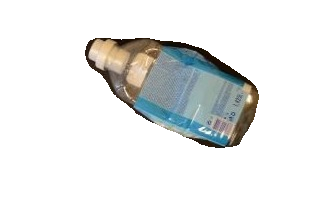

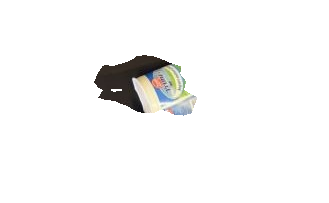

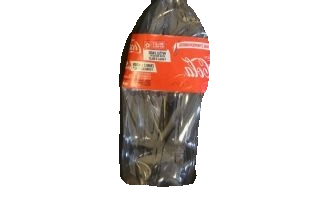

removing invis


IndexError: index 0 is out of bounds for axis 0 with size 0

In [24]:
process = image_proc_2('images','processed_imgs')
process.proc_save(remove_background=True,crop=True,save=True)

In [7]:
generator = imagegen('processed_imgs',6,(900,400),'background.png','output_dir')

In [9]:
a = generator.generate_batch(seed=0,batch_size=100)

# Splitting

In [2]:
splitter = train_val_splitter('processed_imgs','output_dir/labels',output_dir='processed_imgs')

In [3]:
splitter.proc_split()

In [1]:
from main import *

In [2]:
generate_overlapping_images(0.5,'processed_imgs','train','background.png','output_dir_2',size=1)

[5] images were selected
[1 2 0 4 3] were the indices that were selected
